In [1]:

import time
import numpy as np

from sklearn.datasets import load_wine,load_breast_cancer

In [78]:
data = load_breast_cancer()

In [109]:
data.data.shape

(569, 30)

In [79]:
print(data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

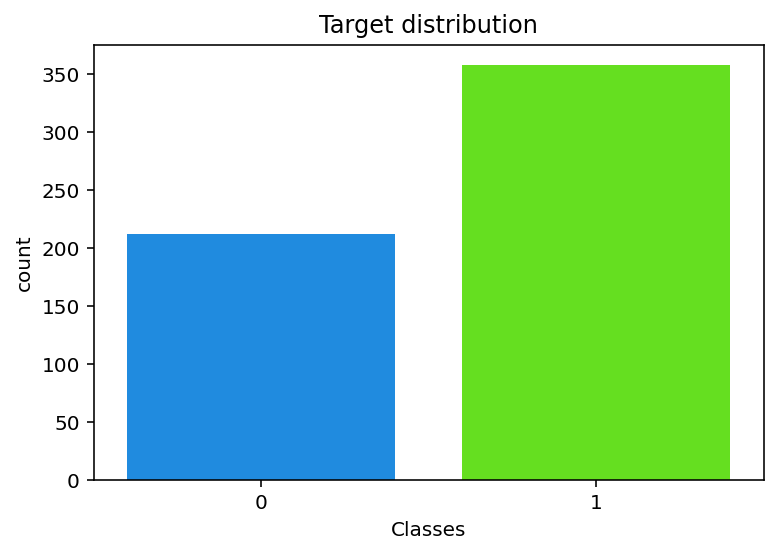

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
sns.countplot(x="target", data=data, palette="gist_rainbow_r")
plt.xlabel("Classes")
plt.title("Target distribution")
plt.show()

In [81]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



len_0 = len(data.target[data.target==0])
len_1 = len(data.target[data.target==1])
new_len = np.min([len_0,len_1])

newtarget = np.hstack((data.target[:new_len],data.target[len_1:len_1+new_len]))
pca = PCA(n_components=2)
scaler = StandardScaler()
features = pca.fit_transform(data.data)
features = scaler.fit_transform(features)
newdata = np.vstack((features[:new_len],features[len_1:len_1+new_len]))
data0 = np.column_stack((newtarget.reshape(len(newtarget),1),newdata[:,:3]))


In [110]:
len_0,len_1

(212, 357)

<Figure size 432x288 with 0 Axes>

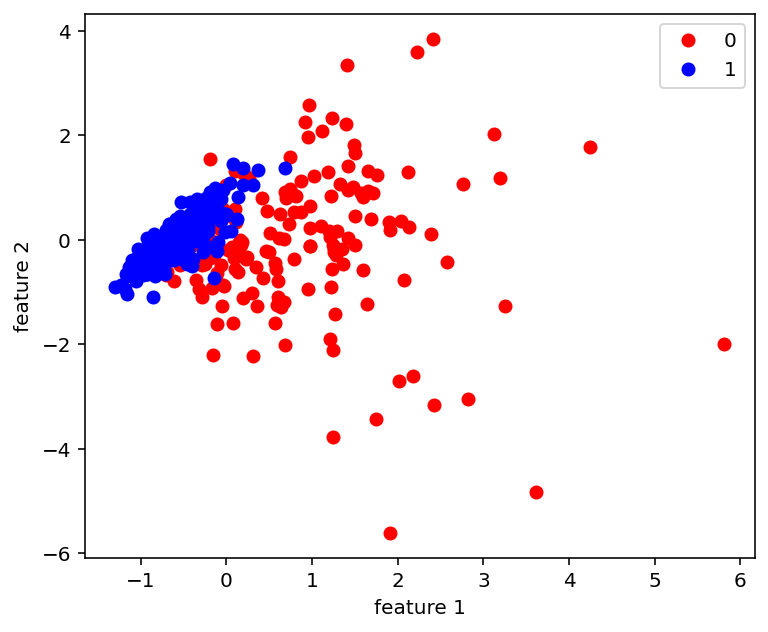

In [86]:
plt.figure(figsize=(6,4))
lbs = data0[:,0]
i1 = np.where(lbs==0)[0]
i2 = np.where(lbs==1)[0]
plt.figure(figsize=(6,5))
plt.plot(data0[:,1][i1],data0[:,2][i1],ls='none',marker='o',color='r',label='0')
plt.plot(data0[:,1][i2],data0[:,2][i2],ls='none',marker='o',color='b',label='1')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

In [88]:

from qiskit import Aer,BasicAer,QuantumCircuit
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import  RealAmplitudes, EfficientSU2, TwoLocal, NLocal, PauliTwoDesign,RealAmplitudes
from qiskit.aqua.components.optimizers import ADAM, SPSA, COBYLA, AQGD, TNC, SLSQP, L_BFGS_B


class DataSet(object):

    """Docstring for CrossValidation. """

    def __init__(self, data, k=None, A=0, B=1):
        """TODO: to be defined. """
        self.data = data.copy()
        self.k = k
        self.A = A
        self.B = B
        #self.C = C
        self.dataA = self.data[self.data[:,0]==self.A]
        self.dataB = self.data[self.data[:,0]==self.B]
        #self.dataC = self.data[self.data[:,0]==self.C]

    def CV(self, data):
        k = self.k
        size = len(data)
        index = np.arange(size)
        np.random.shuffle(index)
        DATA_IND={}
        ind_split = np.array_split(index, k)
        for name in range(k):
            sub = {}
            train_split = []
            for i in range(k):
                if i==name:
                    sub['test_ind'] = ind_split[i]
                else:
                    train_split.append(ind_split[i])
            sub['train_ind'] = np.hstack(train_split)
            DATA_IND.update({name: sub})
        return DATA_IND, index
    
    def data_gen(self):
        ind, _ = self.CV(self.dataA)
        for i in range(self.k):
            tr_input = {
                'A': self.dataA[ind[i]['train_ind']][:,1:],
                'B': self.dataB[ind[i]['train_ind']][:,1:]}
            te_input = {
                'A': self.dataA[ind[i]['test_ind']][:,1:],
                'B': self.dataB[ind[i]['test_ind']][:,1:]}
            te_label = (self.dataA[ind[i]['test_ind']][:,:1],
                        self.dataB[ind[i]['test_ind']][:,:1])
            yield {
                'k': i,
                'tr_input': tr_input, 
                'te_input': te_input,
                'testing_input': np.concatenate((te_input['A'], te_input['B'])),
                'testing_label': np.concatenate(te_label)
                  }



class Main(object):

    """Docstring for CrossValidation. """

    def __init__(self, shots=2048, reps=2, num_qubits=3, fm_func=None, vc_func=None, seed=10598):
        """TODO: to be defined. """
        self.shots = shots
        self.reps = reps
        self.num_qubits = num_qubits
        self.fm_func = fm_func(reps=self.reps,num_qubits=self.num_qubits)
        self.vc_func = vc_func(reps=self.reps+1,num_qubits=self.num_qubits)
        self.seed = seed
        self.counts = []
        self.values = []
        self.backend = Aer.get_backend('qasm_simulator')
        self.backend_options = {"method": "statevector", "max_parallel_threads": 0, "max_parallel_experiments": 2,"max_parallel_shots": 1}
        
    def drawfmap(self, fname):
        return self.fm_func.draw(output='mpl', filename=fname+'_fmap.jpg')
    
    def drawvmap(self, fname):
        return self.vc_func.draw(output='mpl', filename=fname+'_var_circ.jpg')
    
    def call_back_vqc(self, eval_count, var_params, eval_val, index):
        text = "index({}): current cross entropy cost: {}".format(eval_count, eval_val)
        self.counts.append(eval_count)
        self.values.append(eval_val)
        #print(text)
        
    def optimization(self, training_input, test_input):
        self.quantum_instance = QuantumInstance(
            self.backend, 
            shots=self.shots, 
            seed_simulator=self.seed, 
            seed_transpiler=self.seed,
            backend_options=self.backend_options)
        self.vqc = VQC(optimizer=self.opt, 
          feature_map=self.fm_func, 
          var_form=self.vc_func, 
          callback=self.call_back_vqc, 
          training_dataset=training_input,
          test_dataset=test_input) 
    
    def train(self, training_input, test_input):
        self.optimization(training_input, test_input)
        start = time.process_time()

        result = self.vqc.run(self.quantum_instance)
        #val_prob, val_labels = self.vqc.predict(val_input)

        print("time taken: ")
        print(time.process_time() - start)
        print("testing success ratio: {}".format(result['testing_accuracy']))
        return result['testing_accuracy']
    

        
   


In [57]:
np.__version__

'1.20.1'

In [58]:
import qiskit
qiskit.__version__

'0.17.4'

In [75]:
def feature_map_expr1(reps=2, num_qubits=3): 

    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.ry(x[i], i)
            feature_map.rz(x[i], i)
        for i in range(num_qubits - 1, 0, -1):
            feature_map.cx(i, i-1)
            
    return feature_map  

def feature_map_expr2(reps=2, num_qubits=3): 
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.rx(x[i], i)
            feature_map.rz(x[i], i)
        for i in range(num_qubits-1, 0, -1):
            feature_map.cx(i, i-1)
    return feature_map  


def feature_map_expr3(reps=2, num_qubits=3): 
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.rx(x[i], i)
            feature_map.rz(x[i], i)
        for i in range(num_qubits-1, 0, -1):
            feature_map.cz(i, i-1)
    return feature_map 

def feature_map_expr4(reps=2, num_qubits=3): 
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.rx(x[i], i)
            feature_map.rz(x[i], i)
        for control in range(num_qubits-1, -1, -1):
            for target in range(num_qubits-1, -1, -1):
                if control != target:
                    feature_map.rz(x[target], target)
                    feature_map.cx(control, target)
                    feature_map.rz(x[target], target)
    return feature_map 

def feature_map_expr5(reps=2, num_qubits=3): 
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.rx(x[i], i)
            feature_map.rz(x[i], i)
        feature_map.barrier()
        for control in range(num_qubits-1, 0, -1):
            target = control - 1
            feature_map.rx(x[target], target)
            feature_map.cx(control, target)
            feature_map.rx(x[target], target)
            feature_map.barrier()
        for i in range(num_qubits):
            feature_map.rx(x[i], i)
            feature_map.rz(x[i], i)
        feature_map.barrier()
    return feature_map 


def feature_map_expr6(reps=2, num_qubits=3): 
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.ry(x[i], i)
            feature_map.rz(x[i], i)
        for i in range(num_qubits - 1, 0, -1):
            feature_map.cz(i, i-1)
        feature_map.ry(x[1], 1)
        feature_map.rz(x[1], 1)
    return feature_map 


def feature_map_expr7(reps=2, num_qubits=3): 
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    for _ in range(reps):
        for i in range(num_qubits):
            feature_map.ry(x[i], i)
        feature_map.cx(num_qubits-1, 0)
        for i in range(num_qubits-1):
            feature_map.cx(i, i+1)
        for i in range(num_qubits):
            feature_map.ry(x[i], i)
        feature_map.cx(num_qubits - 1, num_qubits - 2)
        feature_map.cx(0, num_qubits - 1)
        for i in range(1, num_qubits - 1):
            feature_map.cx(i, i-1)
    return feature_map 


def feature_map_expr8(reps=2, num_qubits=3): 
    
    return ZZFeatureMap(feature_dimension=num_qubits, reps=reps)
 
def variational_circuit(reps=3, num_qubits=2):
   
    #var_circuit = EfficientSU2(num_qubits, entanglement='linear', reps=2, insert_barriers=True)
    var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=reps)
    # var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], ['cx'], entanglement='linear', reps=4, insert_barriers=True)

    return var_circuit

def variational_circuit1(reps=3, num_qubits=2):
   
    var_circuit = EfficientSU2(num_qubits, entanglement='linear', reps=reps)
    #var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=reps)
    # var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], ['cx'], entanglement='linear', reps=4, insert_barriers=True)

    return var_circuit
def variational_circuit2(reps=3, num_qubits=2):
   
    #var_circuit = EfficientSU2(num_qubits, entanglement='linear', reps=2, insert_barriers=True)
    var_circuit = PauliTwoDesign(num_qubits, reps=reps)
    # var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], ['cx'], entanglement='linear', reps=4, insert_barriers=True)

    return var_circuit

def variational_circuit3(reps=3, num_qubits=2):
   
    #var_circuit = EfficientSU2(num_qubits, entanglement='linear', reps=2, insert_barriers=True)
    var_circuit = RealAmplitudes(num_qubits, reps=reps)
    # var_circuit = TwoLocal(num_qubits, ['ry', 'rz'], ['cx'], entanglement='linear', reps=4, insert_barriers=True)

    return var_circuit


In [89]:
def wrap(data, k=5, feature_map=None, opt_func=None, var_circuit=None, opt_params={}, maxiter=100, reps=2, num_qubits=3,shots=2048, callback=False):
    mds = DataSet(data, k=k, A=0, B=1)
    log = "nqubits({}), reps {}, feature_map {}, opt_func {}:".format(
        num_qubits,
        reps,
        feature_map.__name__,
        opt_func.__name__
    )
    print("="*80+"\n"+log)
    Accuracy = []
    plt.figure(figsize=(5,5))
    with open('result.log', 'a+') as fp:
        result_log = '#'+log+'\n'
        fp.writelines(result_log)
        for d in mds.data_gen():
            print(log+" fold {}...".format(d['k']))
            run = Main(shots=shots,
                       reps=reps, num_qubits=num_qubits, fm_func=feature_map, vc_func=var_circuit)
            run.opt = opt_func(maxiter=maxiter, **opt_params)
            acc = run.train(d['tr_input'], d['te_input'])
            fp.writelines("{}, {}\n".format(d['k'], acc))
            Accuracy.append(acc)
            count = run.counts
            vals = run.values
            plt.plot(count,vals,label='fold '+str(d['k']+1))
    plt.title('Cost value over training set')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()
    
    return np.asarray(Accuracy)
        #run.drawfmap(log.replace(' ',"").replace(",","").replace(":","").replace("(","").replace(")",""))
        #run.drawvmap(log.replace(' ',"").replace(",","").replace(":","").replace("(","").replace(")",""))    
    

## Feature maps

In [101]:
features_maps = [feature_map_expr1, feature_map_expr2, feature_map_expr3, feature_map_expr4, feature_map_expr5, feature_map_expr6, feature_map_expr7, feature_map_expr8 ]

In [102]:
for i,fmap in enumerate(features_maps):
    fmp = fmap(num_qubits=2,reps=1)
    fmp.draw(output='mpl',filename='fmap'+str(i+1)+'.jpg')

In [104]:
vcircuits = [variational_circuit,variational_circuit1,variational_circuit2,variational_circuit3]

for i,vcirc in enumerate(vcircuits):
    fmp = vcirc(num_qubits=2,reps=1)
    fmp.draw(output='mpl',filename='vmap'+str(i+1)+'.jpg')

In [32]:
mds = DataSet(data0, k=3)
feature_map = feature_map_expr1
for d in mds.data_gen():
    print(d['k'], d.keys())
    print(len(d['tr_input']['A']),len(d['te_input']['A']))
    #run = Main(reps=2, num_qubits=3, fm_func=feature_map, vc_func=variational_circuit)
    #run.opt = COBYLA(maxiter=100, disp=True, tol=1e-6)
    #run.train(d['tr_input'], d['te_input'])

0 dict_keys(['k', 'tr_input', 'te_input', 'testing_input', 'testing_label'])
107 54
1 dict_keys(['k', 'tr_input', 'te_input', 'testing_input', 'testing_label'])
107 54
2 dict_keys(['k', 'tr_input', 'te_input', 'testing_input', 'testing_label'])
108 53


nqubits(2), reps 2, feature_map feature_map_expr1, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr1, opt_func COBYLA: fold 0...
time taken: 
287.1957480000001
testing success ratio: 0.7129629629629629
nqubits(2), reps 2, feature_map feature_map_expr1, opt_func COBYLA: fold 1...
time taken: 
297.1329820000001
testing success ratio: 0.75
nqubits(2), reps 2, feature_map feature_map_expr1, opt_func COBYLA: fold 2...
time taken: 
293.7930609999994
testing success ratio: 0.6886792452830188


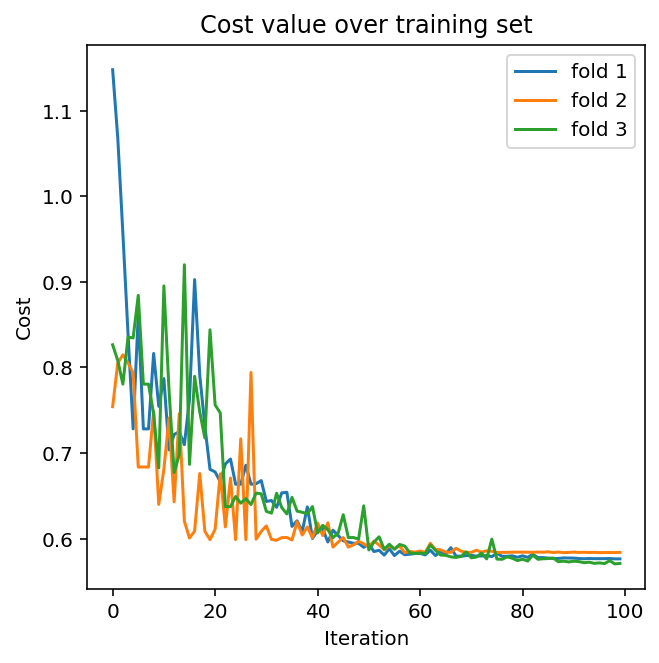

nqubits(2), reps 2, feature_map feature_map_expr2, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr2, opt_func COBYLA: fold 0...
time taken: 
297.14282099999946
testing success ratio: 0.6481481481481481
nqubits(2), reps 2, feature_map feature_map_expr2, opt_func COBYLA: fold 1...
time taken: 
288.7162559999997
testing success ratio: 0.6944444444444444
nqubits(2), reps 2, feature_map feature_map_expr2, opt_func COBYLA: fold 2...
time taken: 
307.6142949999994
testing success ratio: 0.7641509433962265


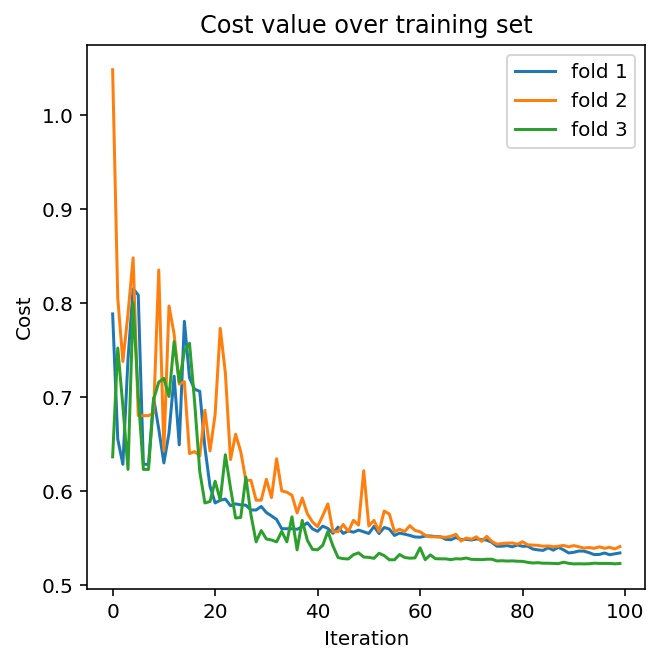

nqubits(2), reps 2, feature_map feature_map_expr3, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr3, opt_func COBYLA: fold 0...
time taken: 
326.32553199999893
testing success ratio: 0.8333333333333334
nqubits(2), reps 2, feature_map feature_map_expr3, opt_func COBYLA: fold 1...
time taken: 
315.51412600000003
testing success ratio: 0.7592592592592593
nqubits(2), reps 2, feature_map feature_map_expr3, opt_func COBYLA: fold 2...
time taken: 
308.7469460000011
testing success ratio: 0.7547169811320755


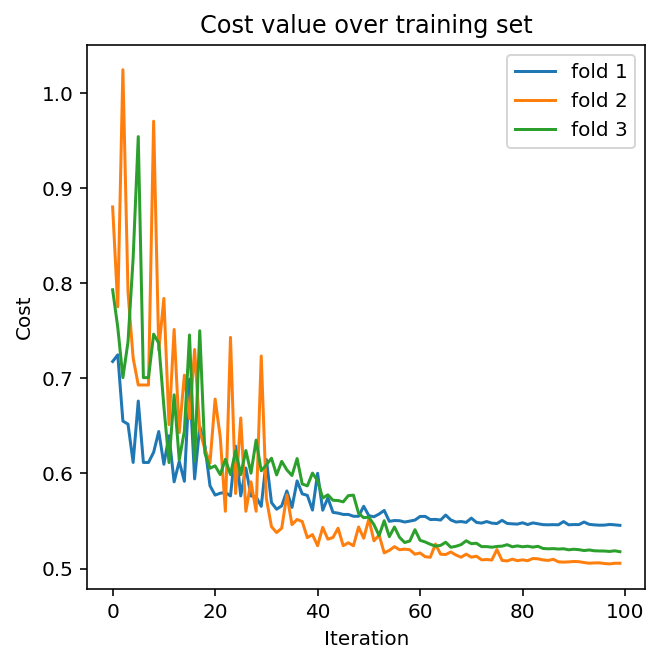

nqubits(2), reps 2, feature_map feature_map_expr4, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr4, opt_func COBYLA: fold 0...
time taken: 
345.6330790000011
testing success ratio: 0.7777777777777778
nqubits(2), reps 2, feature_map feature_map_expr4, opt_func COBYLA: fold 1...
time taken: 
328.08977400000003
testing success ratio: 0.6111111111111112
nqubits(2), reps 2, feature_map feature_map_expr4, opt_func COBYLA: fold 2...
time taken: 
327.4633840000006
testing success ratio: 0.6981132075471698


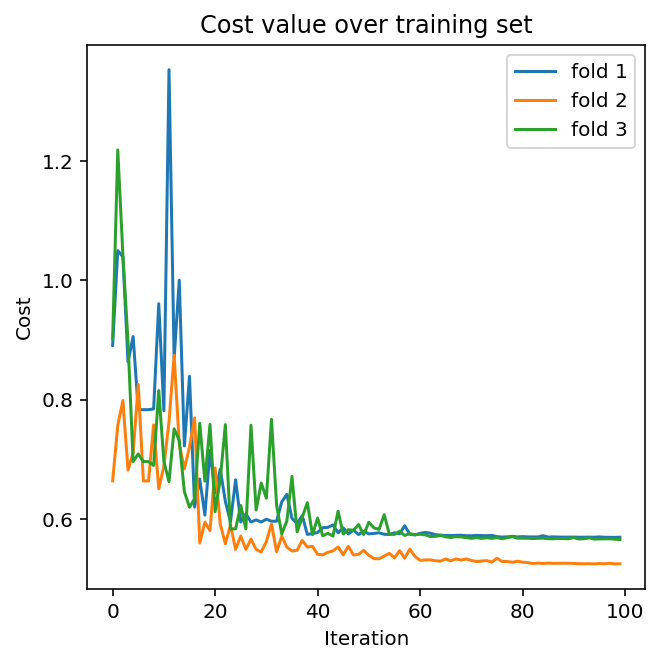

nqubits(2), reps 2, feature_map feature_map_expr5, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr5, opt_func COBYLA: fold 0...
time taken: 
342.7916860000005
testing success ratio: 0.7037037037037037
nqubits(2), reps 2, feature_map feature_map_expr5, opt_func COBYLA: fold 1...
time taken: 
362.0805739999996
testing success ratio: 0.7129629629629629
nqubits(2), reps 2, feature_map feature_map_expr5, opt_func COBYLA: fold 2...
time taken: 
363.5691850000003
testing success ratio: 0.5943396226415094


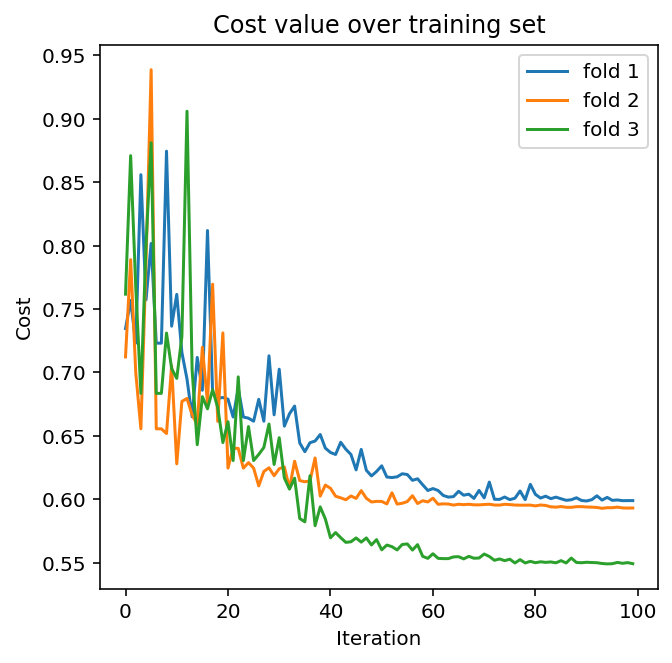

nqubits(2), reps 2, feature_map feature_map_expr6, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr6, opt_func COBYLA: fold 0...
time taken: 
315.29625099999976
testing success ratio: 0.7407407407407407
nqubits(2), reps 2, feature_map feature_map_expr6, opt_func COBYLA: fold 1...
time taken: 
331.9132330000011
testing success ratio: 0.7129629629629629
nqubits(2), reps 2, feature_map feature_map_expr6, opt_func COBYLA: fold 2...
time taken: 
318.06503200000043
testing success ratio: 0.7264150943396226


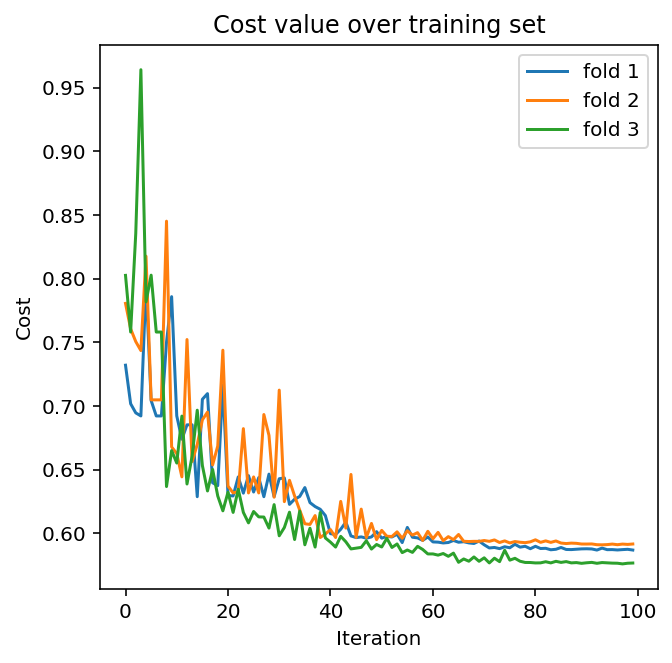

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
316.8158220000005
testing success ratio: 0.8611111111111112
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
270.70803499999965
testing success ratio: 0.8981481481481481
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
251.174140000001
testing success ratio: 0.8301886792452831


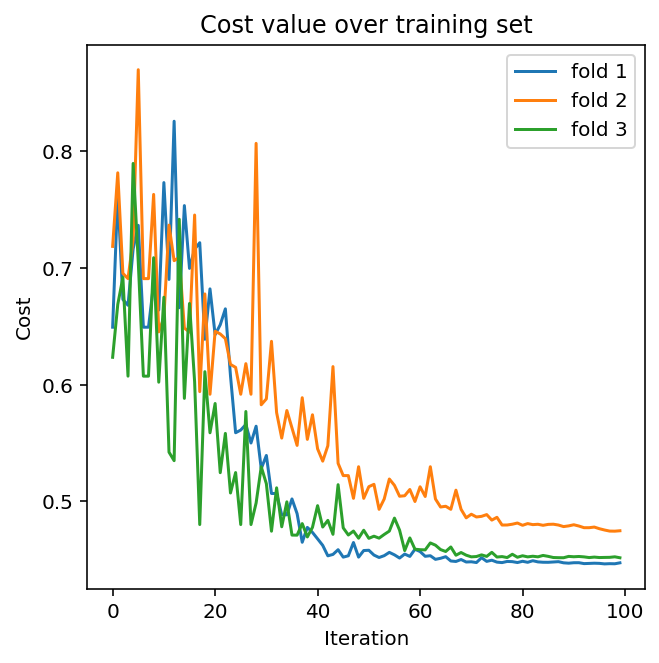

nqubits(2), reps 2, feature_map feature_map_expr8, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr8, opt_func COBYLA: fold 0...
time taken: 
337.67813300000125
testing success ratio: 0.6388888888888888
nqubits(2), reps 2, feature_map feature_map_expr8, opt_func COBYLA: fold 1...
time taken: 
336.35569300000134
testing success ratio: 0.6388888888888888
nqubits(2), reps 2, feature_map feature_map_expr8, opt_func COBYLA: fold 2...
time taken: 
337.5362530000002
testing success ratio: 0.6509433962264151


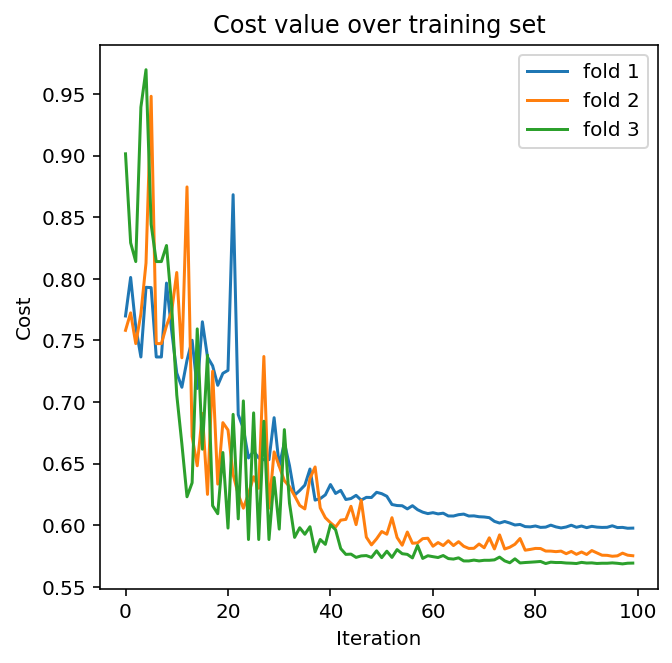

In [34]:
acc_fmap = np.zeros((len(features_maps),3))
params = {"k":3, "maxiter":100, "num_qubits":data0.shape[1]-1, "reps":2}
params["var_circuit"] = variational_circuit
params["opt_func"] = COBYLA
params["opt_params"] = {"disp":True, "tol":1e-6}
for i,fmap in enumerate(features_maps):
    
    params["feature_map"] = fmap
    acc_fmap[i] = wrap(data0, **params)

In [44]:
acc_fmap = np.array([[0.7129629629629629,0.75,0.6886792452830188],
                     [0.6481481481481481,0.6944444444444444,0.7641509433962265],
                     [0.8333333333333334,0.7592592592592593,0.7547169811320755],
                     [0.7777777777777778,0.6111111111111112,0.6981132075471698],
                     [0.7037037037037037,0.7129629629629629,0.5943396226415094],
                     [0.7407407407407407,0.7129629629629629,0.7264150943396226],
                     [0.8611111111111112,0.8981481481481481,0.8301886792452831],
                     [0.6388888888888888,0.6388888888888888,0.6509433962264151]]).reshape(8,3)

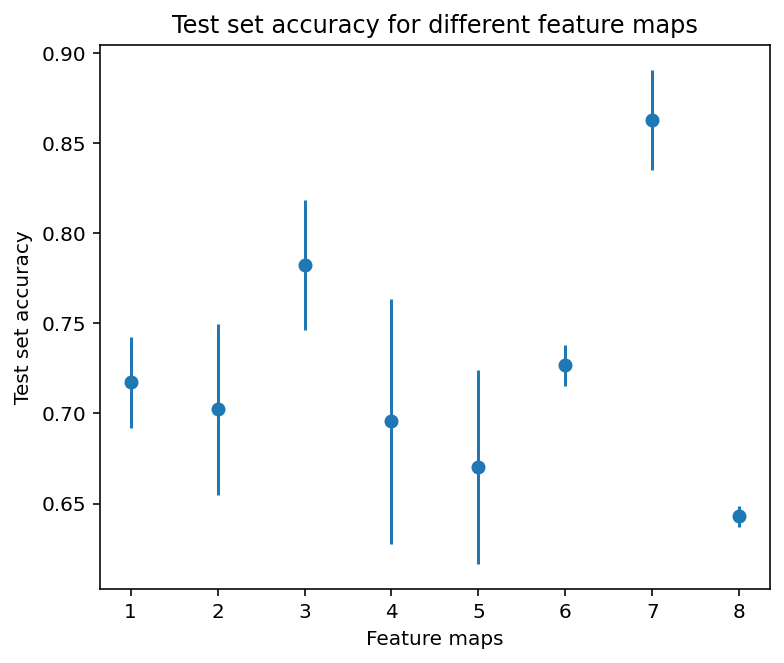

In [52]:
x = np.arange(1,len(acc_fmap)+1,1)
y = np.mean(acc_fmap,axis=1)
yerr = np.std(acc_fmap,axis=1)
plt.figure(figsize=(6,5))
plt.errorbar(x,y,yerr=yerr,ls='none',marker='o')
plt.title('Test set accuracy for different feature maps')
plt.xlabel('Feature maps')
plt.ylabel('Test set accuracy')
plt.show()

## optimizers

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
255.0482329999977
testing success ratio: 0.8425925925925926
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
251.31430499999988
testing success ratio: 0.8981481481481481
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
256.13111500000014
testing success ratio: 0.8018867924528302


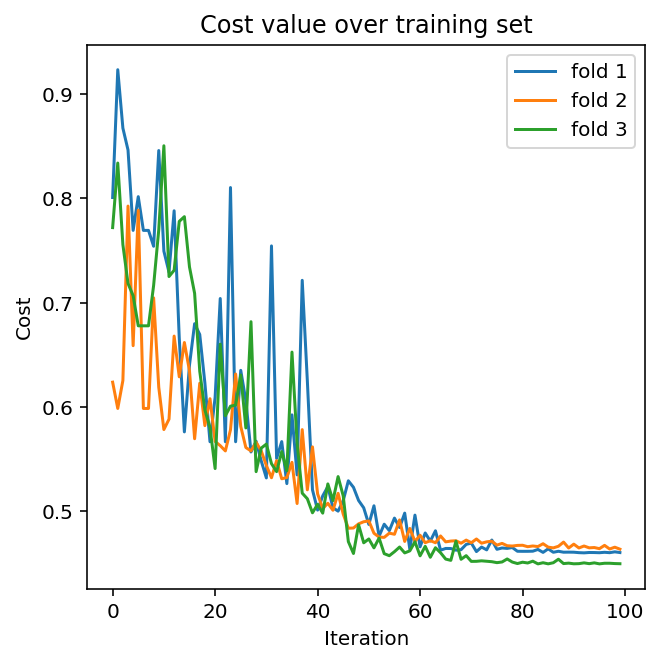

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func SPSA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func SPSA: fold 0...
time taken: 
604.9314579999991
testing success ratio: 0.7962962962962963
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func SPSA: fold 1...
time taken: 
607.1642820000015
testing success ratio: 0.8981481481481481
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func SPSA: fold 2...
time taken: 
617.1511200000023
testing success ratio: 0.839622641509434


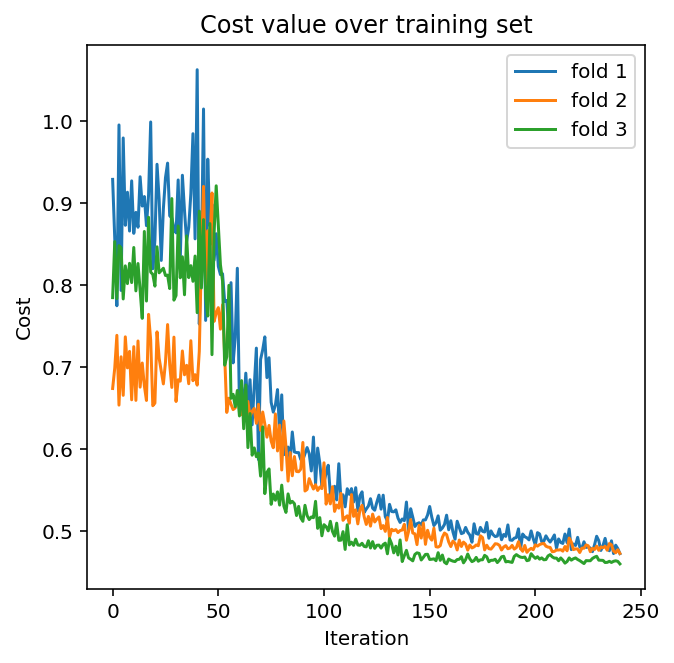

In [71]:
optimizers= ['COBYLA','SPSA']
acc_fmap = np.zeros((len(optimizers),3))
params = {"k":3, "maxiter":100, "num_qubits":data0.shape[1]-1, "reps":2}
params["var_circuit"] = variational_circuit2
params["feature_map"] = feature_map_expr7

for i,rep in enumerate(optimizers):  
    if i == 0:
        params["opt_func"] = COBYLA
        #params["opt_params"] = {"disp":True, "tol":1e-6}
        acc_fmap[i] = wrap(data0, **params)
    else:
        params["opt_func"] = SPSA
        acc_fmap[i] = wrap(data0, **params)
    
   

        
    

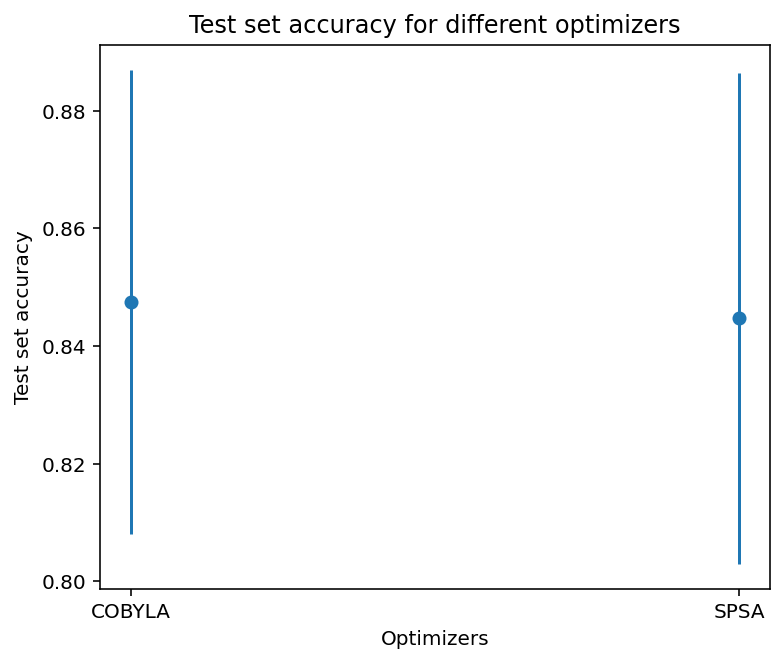

In [72]:
x = optimizers#np.arange(1,len(acc_fmap)+1,1)
y = np.mean(acc_fmap,axis=1)
yerr = np.std(acc_fmap,axis=1)
plt.figure(figsize=(6,5))
plt.errorbar(x,y,yerr=yerr,ls='none',marker='o')
plt.title('Test set accuracy for different optimizers')
plt.xlabel('Optimizers')
plt.ylabel('Test set accuracy')
plt.show()

## Variational circuits

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
255.62331900000208
testing success ratio: 0.8055555555555556
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
256.98036800000045
testing success ratio: 0.8611111111111112
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
257.9418020000012
testing success ratio: 0.9056603773584906


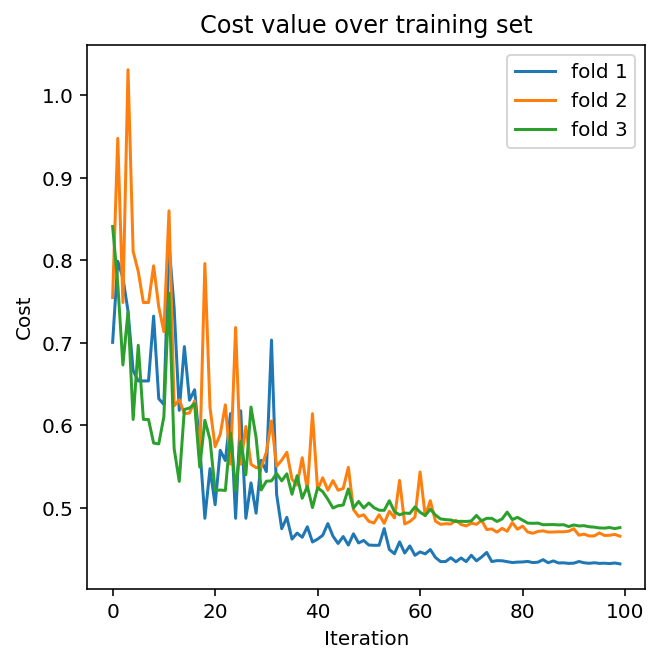

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
253.58787599999778
testing success ratio: 0.8611111111111112
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
253.88607299999785
testing success ratio: 0.8703703703703703
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
256.0812100000003
testing success ratio: 0.8773584905660378


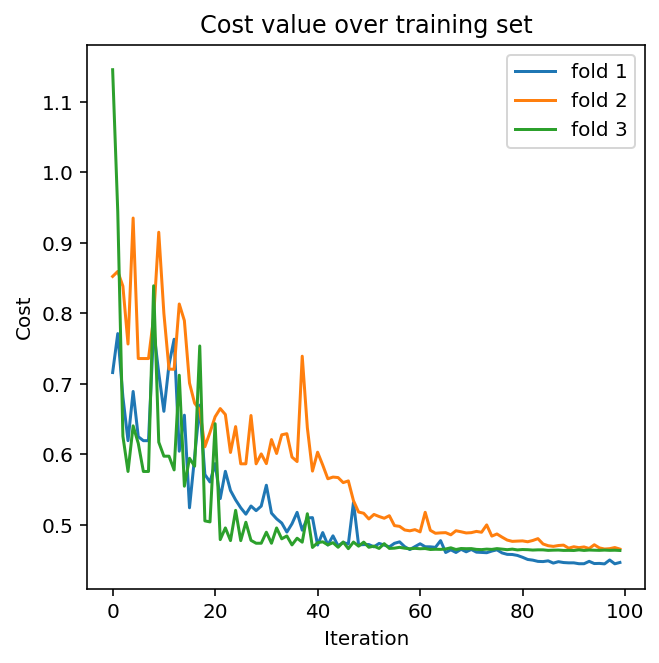

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
216.42575699999725
testing success ratio: 0.8888888888888888
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
213.93325499999992
testing success ratio: 0.8703703703703703
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
214.01817200000005
testing success ratio: 0.8679245283018868


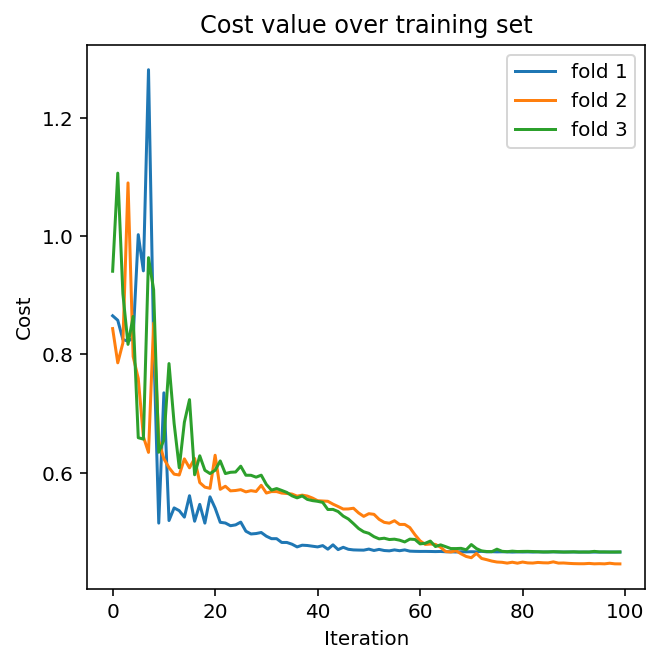

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
216.3055630000017
testing success ratio: 0.6851851851851852
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
213.60991200000353
testing success ratio: 0.6111111111111112
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
212.86186699999962
testing success ratio: 0.660377358490566


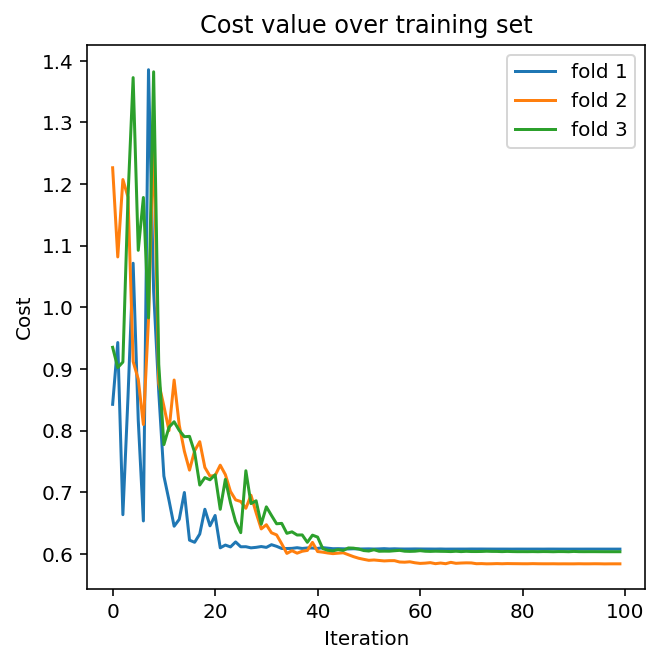

In [76]:
var_circs= [variational_circuit,variational_circuit1,variational_circuit2,variational_circuit3]
acc_fmap = np.zeros((len(var_circs),3))
params = {"k":3, "maxiter":100, "num_qubits":data0.shape[1]-1, "reps":2}
#params["var_circuit"] = variational_circuit
params["feature_map"] = feature_map_expr7
params["opt_func"] = COBYLA
params["opt_params"] = {"disp":True, "tol":1e-6}

for i,circ in enumerate(var_circs):  
    params["var_circuit"] = circ
    acc_fmap[i] = wrap(data0, **params)
    
   

        
    

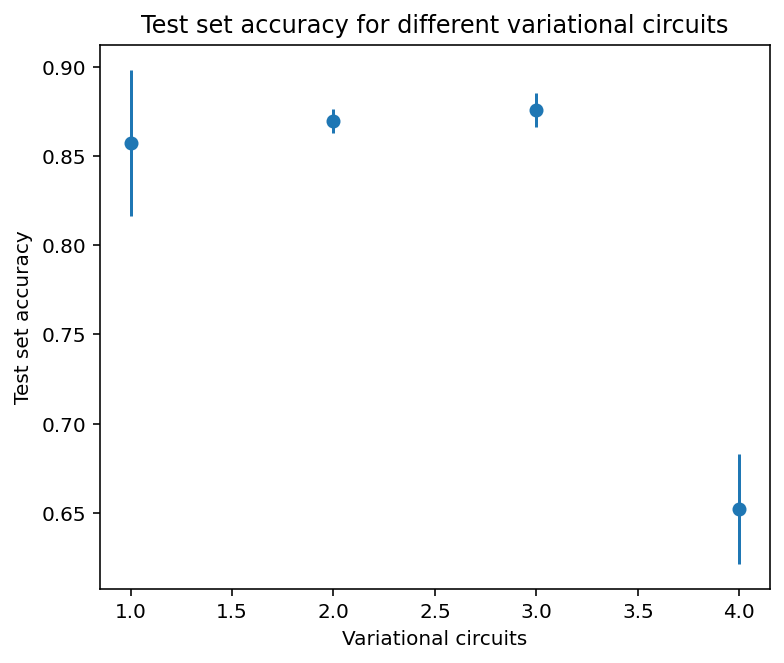

In [77]:
x = np.arange(1,len(acc_fmap)+1,1)
y = np.mean(acc_fmap,axis=1)
yerr = np.std(acc_fmap,axis=1)
plt.figure(figsize=(6,5))
plt.errorbar(x,y,yerr=yerr,ls='none',marker='o')
plt.title('Test set accuracy for different variational circuits')
plt.xlabel('Variational circuits')
plt.ylabel('Test set accuracy')
plt.show()

## Shots

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
159.7564459999994
testing success ratio: 0.7222222222222222
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
160.03178599999956
testing success ratio: 0.6111111111111112
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
160.36012299999857
testing success ratio: 0.6792452830188679


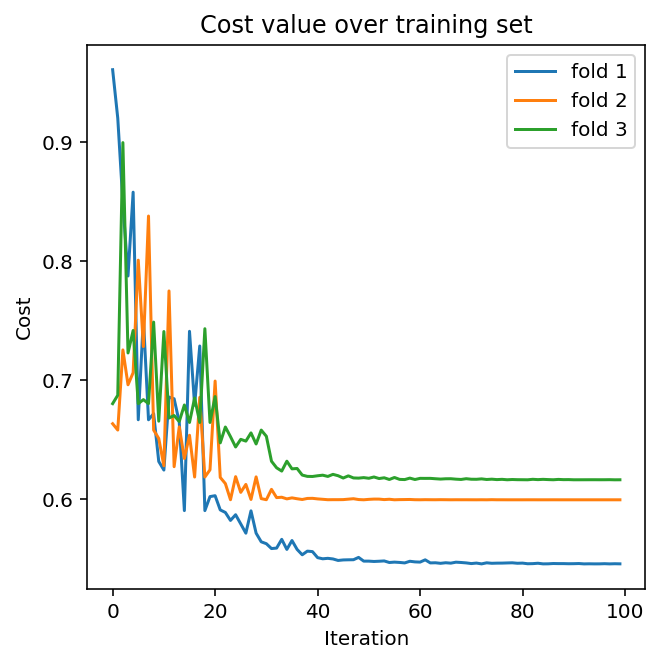

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
177.74246499999936
testing success ratio: 0.9074074074074074
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
177.7922090000029
testing success ratio: 0.8240740740740741
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
178.16206600000078
testing success ratio: 0.8773584905660378


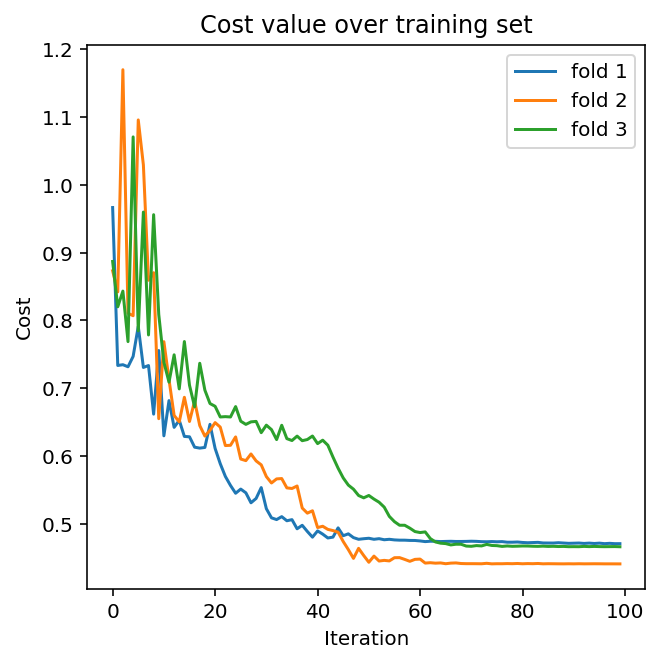

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
211.38285600000017
testing success ratio: 0.8611111111111112
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
221.77013699999952
testing success ratio: 0.8518518518518519
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
218.01685200000065
testing success ratio: 0.8490566037735849


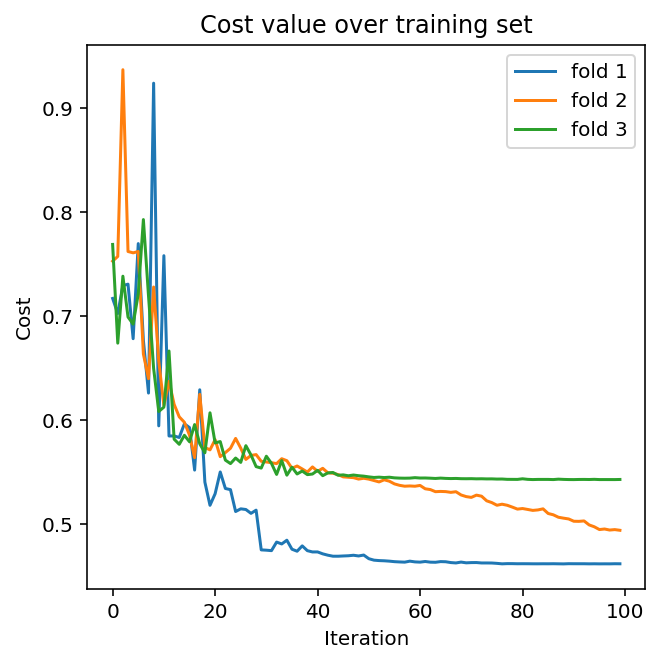

In [90]:
shots = [512,1024,2048]
acc_fmap = np.zeros((len(shots),3))
params = {"k":3, "maxiter":100, "num_qubits":data0.shape[1]-1, "reps":2}
params["var_circuit"] = variational_circuit2
params["feature_map"] = feature_map_expr7
params["opt_func"] = COBYLA
params["opt_params"] = {"disp":True, "tol":1e-6}

for i,shot in enumerate(shots):  
    params["shots"] = shot
    acc_fmap[i] = wrap(data0, **params)
    

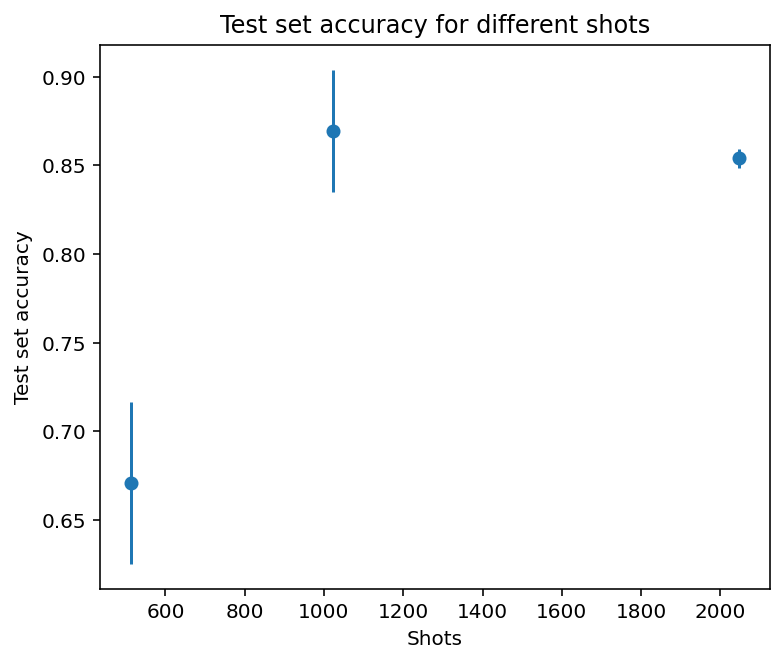

In [91]:
x = shots
y = np.mean(acc_fmap,axis=1)
yerr = np.std(acc_fmap,axis=1)
plt.figure(figsize=(6,5))
plt.errorbar(x,y,yerr=yerr,ls='none',marker='o')
plt.title('Test set accuracy for different shots')
plt.xlabel('Shots')
plt.ylabel('Test set accuracy')
plt.show()

## Qubits

In [92]:
len_0 = len(data.target[data.target==0])
len_1 = len(data.target[data.target==1])
new_len = np.min([len_0,len_1])

newtarget = np.hstack((data.target[:new_len],data.target[len_1:len_1+new_len]))
pca = PCA(n_components=3)
scaler = StandardScaler()
features = pca.fit_transform(data.data)
features = scaler.fit_transform(features)
newdata = np.vstack((features[:new_len],features[len_1:len_1+new_len]))
data1 = np.column_stack((newtarget.reshape(len(newtarget),1),newdata[:,:3]))


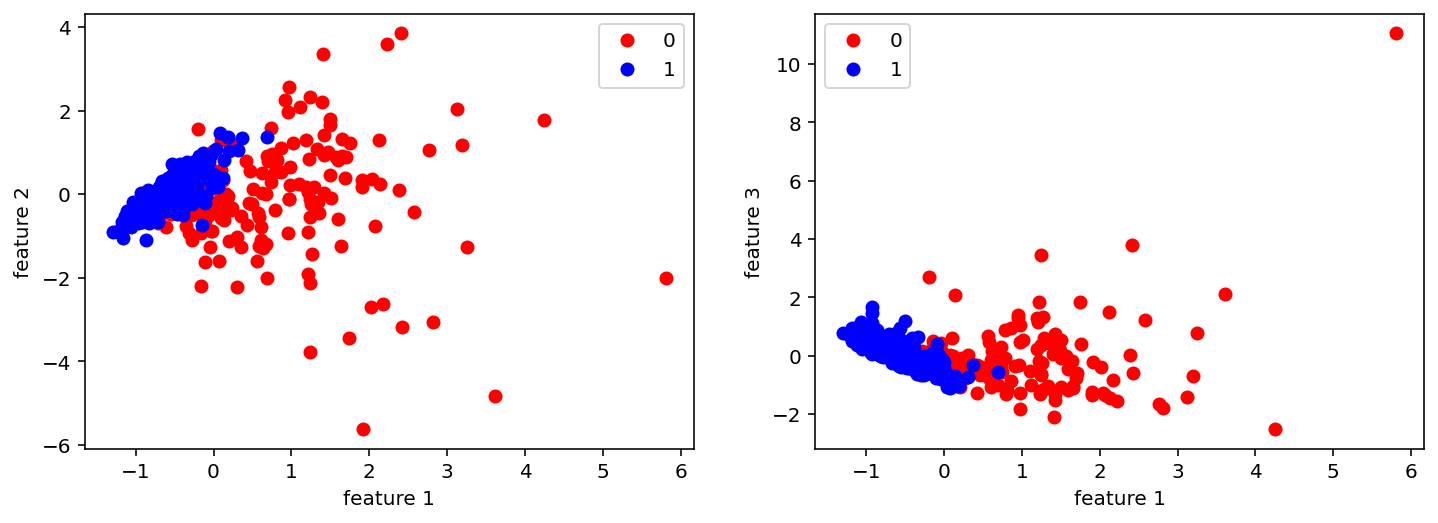

In [106]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
lbs = data1[:,0]
i1 = np.where(lbs==0)[0]
i2 = np.where(lbs==1)[0]
ax[0].plot(data1[:,1][i1],data1[:,2][i1],ls='none',marker='o',color='r',label='0')
ax[0].plot(data1[:,1][i2],data1[:,2][i2],ls='none',marker='o',color='b',label='1')
ax[0].set_xlabel('feature 1')
ax[0].set_ylabel('feature 2')
ax[0].legend()

ax[1].plot(data1[:,1][i1],data1[:,3][i1],ls='none',marker='o',color='r',label='0')
ax[1].plot(data1[:,1][i2],data1[:,3][i2],ls='none',marker='o',color='b',label='1')
ax[1].set_xlabel('feature 1')
ax[1].set_ylabel('feature 3')
ax[1].legend()
plt.show()

nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
252.90346599999611
testing success ratio: 0.8796296296296297
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
256.9165060000014
testing success ratio: 0.8518518518518519
nqubits(2), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
255.3071029999992
testing success ratio: 0.8679245283018868


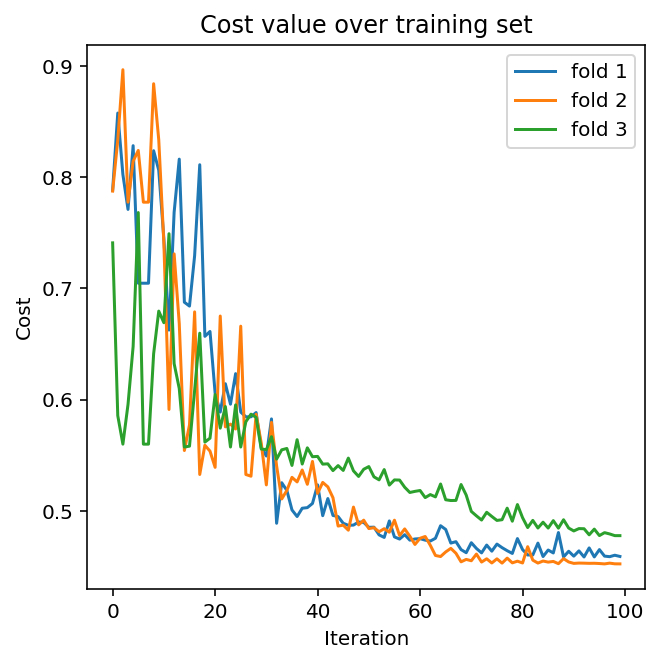

nqubits(3), reps 2, feature_map feature_map_expr7, opt_func COBYLA:
nqubits(3), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 0...
time taken: 
348.51628399999754
testing success ratio: 0.7592592592592593
nqubits(3), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 1...
time taken: 
346.953379999999
testing success ratio: 0.8148148148148148
nqubits(3), reps 2, feature_map feature_map_expr7, opt_func COBYLA: fold 2...
time taken: 
352.79030399999465
testing success ratio: 0.8207547169811321


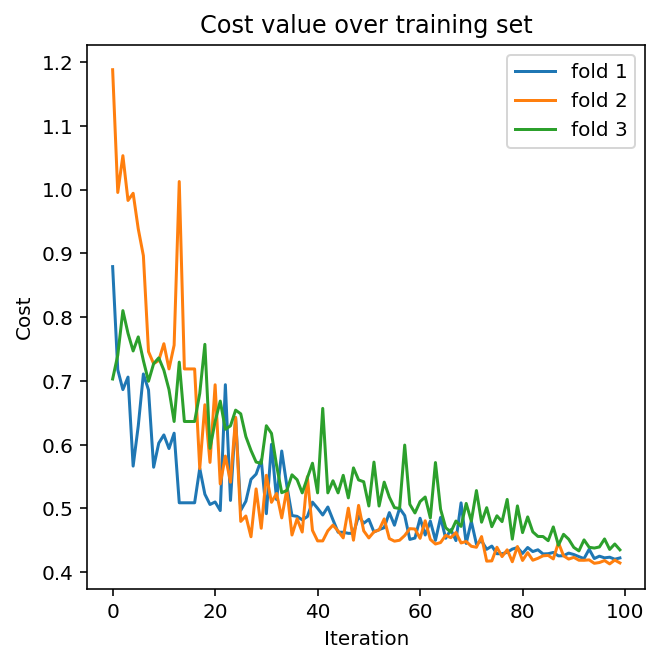

In [97]:
qubits = [data0,data1]
acc_fmap = np.zeros((len(qubits),3))
for i in range(2):
    params = {"k":3, "maxiter":100, "num_qubits":qubits[i].shape[1]-1, "reps":2}
    params["var_circuit"] = variational_circuit
    params["feature_map"] = feature_map_expr7
    params["opt_func"] = COBYLA
    params["opt_params"] = {"disp":True, "tol":1e-6}
    acc_fmap[i] = wrap(qubits[i], **params)

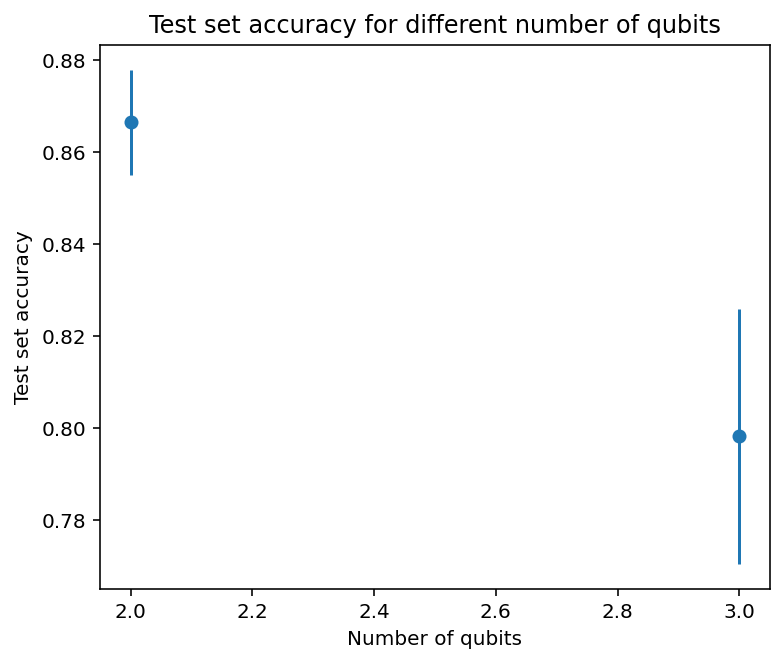

In [100]:
x = [2,3]
y = np.mean(acc_fmap,axis=1)
yerr = np.std(acc_fmap,axis=1)
plt.figure(figsize=(6,5))
plt.errorbar(x,y,yerr=yerr,ls='none',marker='o')
plt.title('Test set accuracy for different number of qubits')
plt.xlabel('Number of qubits')
plt.ylabel('Test set accuracy')
plt.show()